<a href="https://colab.research.google.com/github/modichirag/flowpm/blob/cleanup/flowpm_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install --quiet git+https://github.com/modichirag/flowpm.git@cleanup

     |████████████████████████████████| 368kB 8.9MB/s 


In [5]:
%pylab inline
import tensorflow as tf
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [6]:
# Define key parameters of our Universe
a0      = 0.1       #the initial epoch from where we begin the evolution, a0=0 corresponds to birth but is numerically unstable
af      = 1.0       #final epoch where we visualize structures, af=1 corresponds to today
n_steps = 10        #number of time-steps to split the total evolution into
L       = 100       #Physical size of the Universe in Mpc/h
N       = 32        #Number of mesh-points along one axis, size of the cube. Then the number of particles will be N^3
batch   = 16        #Batch size, how many independent Universes to simulate

In [7]:
import flowpm
from flowpm.tfpower import linear_matter_power
from flowpm.tfbackground import cosmo

@tf.function
def simulation(om, s8):
    cosmo['sigma8'] = tf.convert_to_tensor(s8, dtype=tf.float32)
    cosmo['Omega0_m'] = tf.convert_to_tensor(om, dtype=tf.float32)
    
    stages = np.linspace(a0, af, n_steps, endpoint=True) #time-steps for the integration
    
    initial_conditions = flowpm.linear_field(N,          # size of the cube
                                             L,          # Physical size of the cube
                                             lambda k: tf.cast(linear_matter_power(cosmo, k), tf.complex64), # Initial powerspectrum
                                             batch_size=16)

    # Sample particles
    state = flowpm.lpt_init(initial_conditions, a0)   

    # Evolve particles down to z=0
    final_state = flowpm.nbody(state, stages, 32)         

    # Retrieve final density field
    final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])
    
    return final_field

In [8]:
final_field = simulation(0.3075, 0.8159)

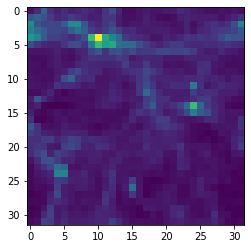

In [9]:
imshow(final_field[0].numpy().sum(axis=0))